In [2]:
import networkx as nx

NetworkXにおいて、グラフのノードとエッジは辞書形式で表される。

In [18]:
G = nx.Graph()

G.add_node(1, name="a", hobby="t") 
G.add_node(2, node="b", hobby="s")
G.add_node(3, name="c", hobby="t")
G.add_edge(1, 2)
G.add_edge(1, 3)
print(G.nodes(data=True))
print(G.edges(data=True))

[(1, {'name': 'a', 'hobby': 't'}), (2, {'node': 'b', 'hobby': 's'}), (3, {'name': 'c', 'hobby': 't'})]
[(1, 2, {}), (1, 3, {})]


In [19]:
nx.to_numpy_array(G, order="C")

array([[0., 1., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [20]:
nx.to_dict_of_dicts(G)

{1: {2: {}, 3: {}}, 2: {1: {}}, 3: {1: {}}}

In [4]:
G = nx.Graph()
print(G.is_directed())
H = nx.DiGraph()
H.is_directed()

False


True

In [5]:
G.graph["Name"] = "Bar"
print(G.graph)

{'Name': 'Bar'}


In [6]:
G.add_node(0, feature=5, label=0)
G.add_node(1, feature=1, label=0)
print(G.nodes[0], G.nodes[1])

{'feature': 5, 'label': 0} {'feature': 1, 'label': 0}


In [7]:
G.add_nodes_from([
    (3, {"feature": 1, "label": 1}),
    (4, {"feature": 2, "label": 1}),
    (5, {"feature": 1, "label": 2}),
])
G.nodes

NodeView((0, 1, 3, 4, 5))

In [8]:
G.add_node(2, a=1, b=2)

In [9]:
G.nodes[2]

{'a': 1, 'b': 2}

In [10]:
for node in G.nodes(data=True):
    print(node)

G.is_multigraph()

(0, {'feature': 5, 'label': 0})
(1, {'feature': 1, 'label': 0})
(3, {'feature': 1, 'label': 1})
(4, {'feature': 2, 'label': 1})
(5, {'feature': 1, 'label': 2})
(2, {'a': 1, 'b': 2})


False

In [11]:
G.add_edge(0, 1, weight=0.5)
G.add_edge(1, 2, weight=-1)
G.add_edges_from([
    (1, 2),
    (2, 5),
    (3, 5),
    (4, 5),
    (1, 4),
])
for edge in G.edges(data=True):
    print(edge)

(0, 1, {'weight': 0.5})
(1, 2, {'weight': -1})
(1, 4, {})
(3, 5, {})
(4, 5, {})
(5, 2, {})


In [12]:
num_edges = G.number_of_edges()
num_edges

6

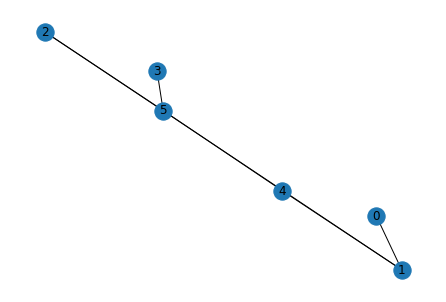

In [13]:
nx.draw(G, with_labels=True)

In [14]:
print(G.degree[1], G.degree[3])

for neighbor in G.neighbors(1):
    print(neighbor)

3 1
0
2
4


In [15]:
# Helper function for visualization.
# %matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")

    plt.show()

In [18]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [19]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 9.18
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


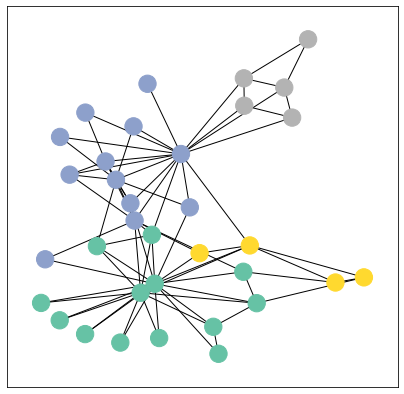

In [22]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [43]:
num_layers = 2
input_dim = 34
hidden_dim = 4

In [44]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.classifier = Linear(2, dataset.num_classes)

        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        for l in range(num_layers):
          self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.convs.append(GCNConv(hidden_dim, 2))

    def forward(self, x, edge_index):

        for l in range(num_layers - 1):
          x = self.convs[l](x, edge_index)
          x = x.tanh()

        h = F.relu(x)    
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.convs[-1](h, edge_index)
        embeddings = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(embeddings)

        return out, embeddings

model = GCN()
print(model)

GCN(
  (classifier): Linear(in_features=2, out_features=4, bias=True)
  (convs): ModuleList(
    (0): GCNConv(34, 4)
    (1): GCNConv(4, 4)
    (2): GCNConv(4, 4)
    (3): GCNConv(4, 2)
  )
)


Embedding shape: [34, 2]


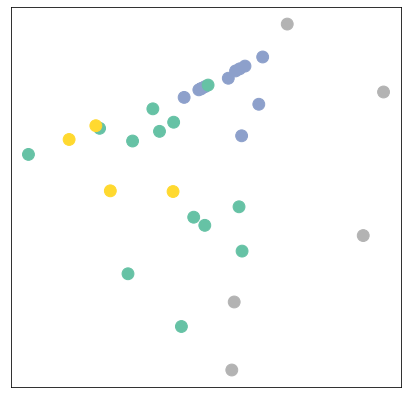

In [45]:
_, emb = model(data.x, data.edge_index)
print(f'Embedding shape: {list(emb.shape)}')

visualize(emb, color=data.y)

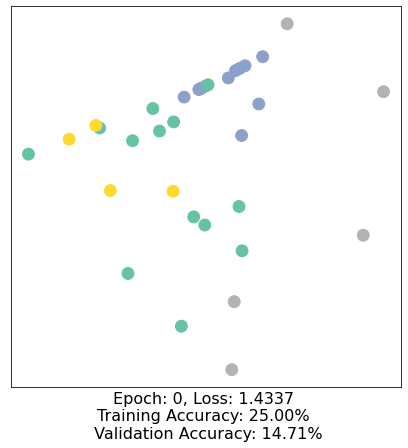

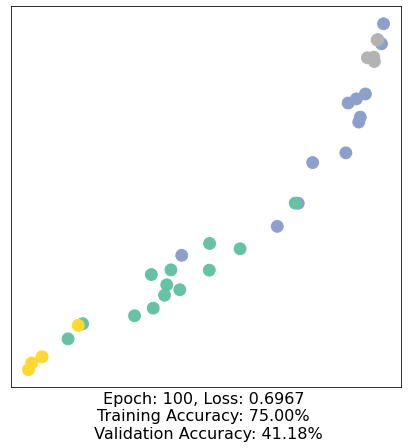

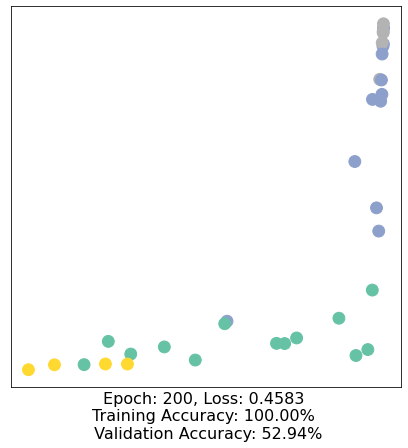

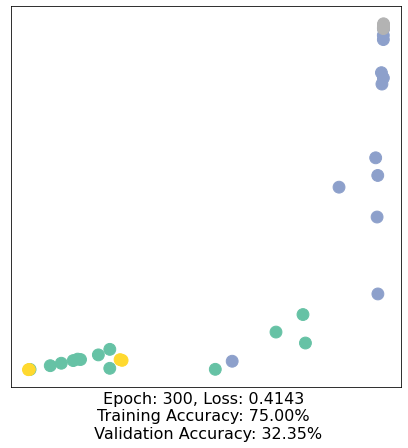

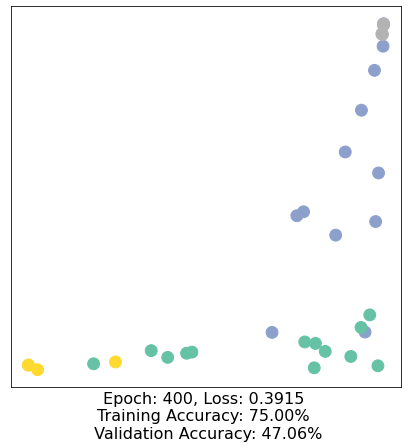

In [47]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(500):
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 100 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)